In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import scale

In [2]:
df = pd.read_excel('Brazillian_e-commerce_Final.xlsx')

In [3]:
#df.info()
df=df.reset_index(drop=True)

In [4]:
#DROP COLUMNS THAT ARE NOT NEEDED

df = df[['order_id','product_id', 'customer_id', 'order_status', 'price', 'freight_value', 
         'order_purchase_timestamp', 'order_approved_at', 'order_estimated_delivery_date', 'order_delivered_customer_date',
        'customer_state', 'product_description_lenght', 'product_photos_qty','product_category_name', 'review_score']]

#df.info()

In [5]:
#df = df[:50000]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111689 entries, 0 to 111688
Data columns (total 15 columns):
order_id                         111689 non-null object
product_id                       111686 non-null object
customer_id                      111686 non-null object
order_status                     111689 non-null object
price                            111689 non-null object
freight_value                    111686 non-null float64
order_purchase_timestamp         111686 non-null datetime64[ns]
order_approved_at                111672 non-null datetime64[ns]
order_estimated_delivery_date    111686 non-null datetime64[ns]
order_delivered_customer_date    109280 non-null datetime64[ns]
customer_state                   111686 non-null object
product_description_lenght       111686 non-null float64
product_photos_qty               111686 non-null float64
product_category_name            111683 non-null object
review_score                     111686 non-null float64
dtypes: datet

# Removing NA values

In [6]:
# Lets check for NA values
df.isnull().sum()

order_id                            0
product_id                          3
customer_id                         3
order_status                        0
price                               0
freight_value                       3
order_purchase_timestamp            3
order_approved_at                  17
order_estimated_delivery_date       3
order_delivered_customer_date    2409
customer_state                      3
product_description_lenght          3
product_photos_qty                  3
product_category_name               6
review_score                        3
dtype: int64

In [7]:
# Dropping all NA values assuming that the order was never approved or delivered and that the data related to it is incorrect
df = df.dropna()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109263 entries, 0 to 111688
Data columns (total 15 columns):
order_id                         109263 non-null object
product_id                       109263 non-null object
customer_id                      109263 non-null object
order_status                     109263 non-null object
price                            109263 non-null object
freight_value                    109263 non-null float64
order_purchase_timestamp         109263 non-null datetime64[ns]
order_approved_at                109263 non-null datetime64[ns]
order_estimated_delivery_date    109263 non-null datetime64[ns]
order_delivered_customer_date    109263 non-null datetime64[ns]
customer_state                   109263 non-null object
product_description_lenght       109263 non-null float64
product_photos_qty               109263 non-null float64
product_category_name            109263 non-null object
review_score                     109263 non-null float64
dtypes: datet

# Creating our target variable: Delivery time

#### Checking whether the dates are not falling on any Public holidays in Brazil

In [9]:
df['order_approved_at'].min(), df['order_estimated_delivery_date'].max()

(Timestamp('2016-09-15 12:16:00'), Timestamp('2018-10-25 00:00:00'))

In [10]:
total_days = df.filter(['order_approved_at', 'order_estimated_delivery_date', 'order_delivered_customer_date'], axis=1)

In [11]:
total_days.head()

,order_approved_at,order_estimated_delivery_date,order_delivered_customer_date
0,2017-10-02 11:07:00,2017-10-18,2017-10-10 21:25:00
1,2018-07-26 03:24:00,2018-08-13,2018-08-07 15:27:00
2,2018-08-08 08:55:00,2018-09-04,2018-08-17 18:06:00
3,2017-11-18 19:45:00,2017-12-15,2017-12-02 00:28:00
4,2018-02-13 22:20:00,2018-02-26,2018-02-16 18:17:00


In [209]:
import datetime as dt

# Public Holidays in Brazil as per https://en.wikipedia.org/wiki/Public_holidays_in_Brazil specific for our Date Range

public_holidays = [dt.datetime(2016,1,1), dt.datetime(2016,4,21), dt.datetime(2016,5,1), dt.datetime(2016,9,7), dt.datetime(2016,10,12),
                   dt.datetime(2016,11,2), dt.datetime(2016,11,15), dt.datetime(2016,12,25),
                   dt.datetime(2017,1,1), dt.datetime(2017,4,21), dt.datetime(2017,5,1), dt.datetime(2017,9,7), dt.datetime(2017,10,12),
                   dt.datetime(2017,11,2), dt.datetime(2017,11,15), dt.datetime(2017,12,25),
                   dt.datetime(2018,1,1), dt.datetime(2018,4,21), dt.datetime(2018,5,1), dt.datetime(2018,9,7), dt.datetime(2018,10,12),
                   dt.datetime(2018,11,2), dt.datetime(2018,11,15), dt.datetime(2018,12,25)]

for d in total_days['order_approved_at']:
    if d in public_holidays:
        print(d)

In [210]:
for d in total_days['order_estimated_delivery_date']:
    if d in public_holidays:
        print(d)

In [211]:
for d in total_days['order_delivered_customer_date']:
    if d in public_holidays:
        print(d)

##### No dates fall on Public Holidays

##### Lets convert the datetime features in days count

In [12]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

In [13]:
# Days Estimated Delivery Time
df['estimated_delivery_time'] = (df.loc[:,'order_estimated_delivery_date'] - df.loc[:,'order_approved_at'])
df['estimated_delivery_time'] = df['estimated_delivery_time'].dt.days
df['estimated_delivery_time'].head()

0    15
1    17
2    26
3    26
4    12
Name: estimated_delivery_time, dtype: int64

In [14]:
# Days Actual Delivery Time
df['actual_delivery_time'] = (df.loc[:,'order_delivered_customer_date'] - df.loc[:,'order_approved_at'])
df['actual_delivery_time'] = df['actual_delivery_time'].dt.days
df['actual_delivery_time'].head()

0     8
1    12
2     9
3    13
4     2
Name: actual_delivery_time, dtype: int64

##### Only taking values greater than 0 as the least number of days it takes to deliver an order should be 1

In [15]:
df = df.loc[df['estimated_delivery_time'] > 0]
df = df.loc[df['actual_delivery_time'] > 0]

In [16]:
df['actual_delivery_time'].describe()

count    108988.000000
mean         11.576697
std           9.393970
min           1.000000
25%           6.000000
50%           9.000000
75%          15.000000
max         208.000000
Name: actual_delivery_time, dtype: float64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108988 entries, 0 to 111688
Data columns (total 17 columns):
order_id                         108988 non-null object
product_id                       108988 non-null object
customer_id                      108988 non-null object
order_status                     108988 non-null object
price                            108988 non-null object
freight_value                    108988 non-null float64
order_purchase_timestamp         108988 non-null datetime64[ns]
order_approved_at                108988 non-null datetime64[ns]
order_estimated_delivery_date    108988 non-null datetime64[ns]
order_delivered_customer_date    108988 non-null datetime64[ns]
customer_state                   108988 non-null object
product_description_lenght       108988 non-null float64
product_photos_qty               108988 non-null float64
product_category_name            108988 non-null object
review_score                     108988 non-null float64
estimated_del

In [18]:
# Dropping other datetime features

cols2drop = ['order_purchase_timestamp', 'order_approved_at', 'order_estimated_delivery_date', 'order_delivered_customer_date']
df.drop(cols2drop, axis=1, inplace=True)
df.head()

,order_id,product_id,customer_id,order_status,price,freight_value,customer_state,product_description_lenght,product_photos_qty,product_category_name,review_score,estimated_delivery_time,actual_delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,9ef432eb6251297304e76186b10a928d,delivered,29.99,8.72,SP,268.0,4.0,housewares,4.0,15,8
1,53cdb2fc8bc7dce0b6741e2150273451,595fac2a385ac33a80bd5114aec74eb8,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,118.7,22.76,BA,178.0,1.0,perfumery,4.0,17,12
2,47770eb9100c2d0c44946d9cf07ec65d,aa4383b373c6aca5d8797843e5594415,41ce2a54c0b03bf3443c3d931a367089,delivered,159.9,19.22,GO,232.0,1.0,auto,5.0,26,9
3,949d5b44dbf5de918fe9c16f97b45f8a,d0b61bfb1de832b15ba9d266ca96e5b0,f88197465ea7920adcdbec7375364d82,delivered,45,27.20,RN,468.0,3.0,pet_shop,5.0,26,13
4,ad21c59c0840e6cb83a9ceb5573f8159,65266b2da20d04dbe00c5c2d3bb7859e,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,19.9,8.72,SP,316.0,4.0,stationery,5.0,12,2


In [19]:
# Checking unique values in all features

def unique_col_values(df):
    for column in df:
        print("{} | {} | {}".format(
            df[column].name, len(df[column].unique()), df[column].dtype
        ))
unique_col_values(df)

order_id | 94874 | object
product_id | 31570 | object
customer_id | 94874 | object
order_status | 2 | object
price | 5785 | object
freight_value | 6901 | float64
customer_state | 27 | object
product_description_lenght | 2943 | float64
product_photos_qty | 19 | float64
product_category_name | 71 | object
review_score | 5 | float64
estimated_delivery_time | 97 | int64
actual_delivery_time | 139 | int64


In [20]:
# Removing the features that will not be useful

del df['order_id']
del df['product_id']
del df['customer_id']
del df['order_status']
#df.head()

actual_delivery_time          1.000000
estimated_delivery_time       0.378720
freight_value                 0.211913
product_description_lenght    0.004342
product_photos_qty           -0.026664
review_score                 -0.305252
Name: actual_delivery_time, dtype: float64


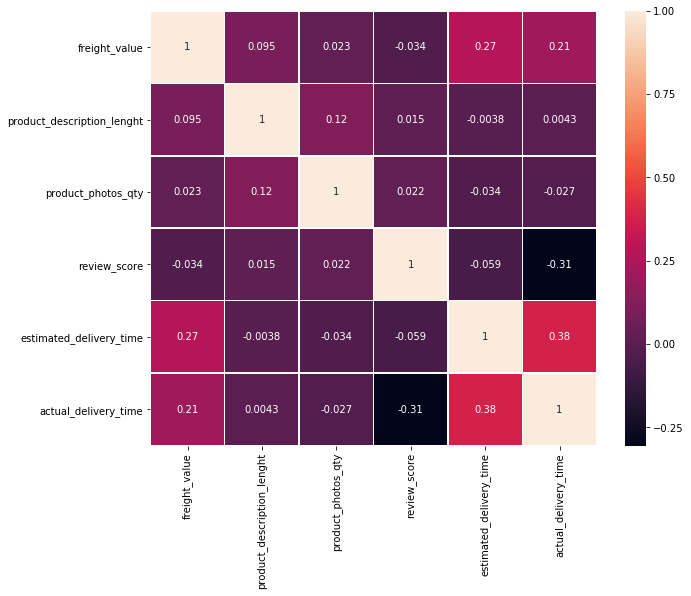

In [21]:
corr_matrix = df.corr()
print(corr_matrix['actual_delivery_time'].sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(10,8))
hm = sns.heatmap(corr_matrix, annot = True, linewidths=.5, ax = ax)

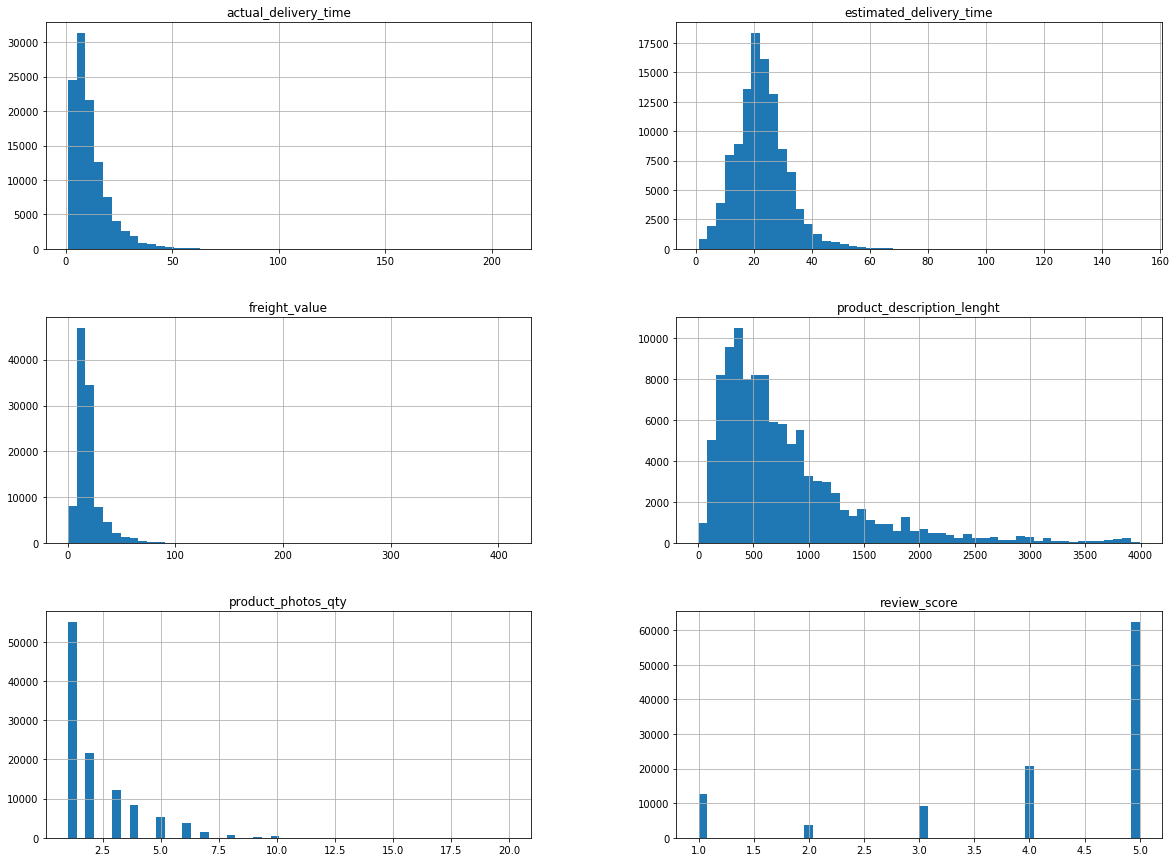

In [22]:
%matplotlib inline

df.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

In [23]:
# Converting price to float and checking null values

df['price'] = pd.to_numeric(df['price'])
df = df[df['price'].notnull()]

Text(0, 0.5, 'Frequency')

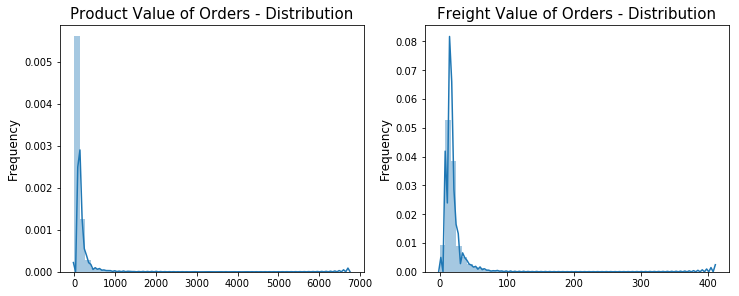

In [25]:
plt.figure(figsize=(12,10))

plt.subplot(221)
g = sns.distplot(df['price'])
g.set_title("Product Value of Orders - Distribution", fontsize=15)
g.set_xlabel("")
g.set_ylabel("Frequency", fontsize=12)

plt.subplot(222)
g1 = sns.distplot(df['freight_value'])
g1.set_title("Freight Value of Orders - Distribution", fontsize=15)
g1.set_xlabel("")
g1.set_ylabel("Frequency", fontsize=12)

### Applying Linear Regression without any transformations

In [26]:
X = df.iloc[:,:-1]
y = df['actual_delivery_time']

In [27]:
# turn X into dict
X_dict = X.to_dict(orient='records') # turn each row as key-value pairs
X_dict[0]

{'price': 29.99,
 'freight_value': 8.72,
 'customer_state': 'SP',
 'product_description_lenght': 268.0,
 'product_photos_qty': 4.0,
 'product_category_name': 'housewares',
 'review_score': 4.0,
 'estimated_delivery_time': 15}

In [28]:
# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

dv_X = DictVectorizer(sparse=False) 
# sparse = False means the output is not a sparse matrix
# apply dv_X on X_dict
X_encoded = dv_X.fit_transform(X_dict)
# show X_encoded
X_encoded

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 2.680e+02, 4.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.780e+02, 1.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.320e+02, 1.000e+00,
        5.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.690e+02, 1.000e+00,
        5.000e+00]])

In [29]:
dv_X.vocabulary_

{'price': 29,
 'freight_value': 28,
 'customer_state=SP': 25,
 'product_description_lenght': 101,
 'product_photos_qty': 102,
 'product_category_name=housewares': 79,
 'review_score': 103,
 'estimated_delivery_time': 27,
 'customer_state=BA': 4,
 'product_category_name=perfumery': 89,
 'customer_state=GO': 8,
 'product_category_name=auto': 35,
 'customer_state=RN': 19,
 'product_category_name=pet_shop': 90,
 'product_category_name=stationery': 96,
 'customer_state=PR': 17,
 'customer_state=RJ': 18,
 'customer_state=RS': 22,
 'product_category_name=furniture_decor': 69,
 'product_category_name=office_furniture': 87,
 'product_category_name=garden_tools': 72,
 'product_category_name=computers_accessories': 45,
 'customer_state=MG': 10,
 'product_category_name=bed_bath_table': 37,
 'product_category_name=toys': 99,
 'product_category_name=construction_tools_construction': 47,
 'customer_state=SC': 23,
 'product_category_name=telephony': 98,
 'product_category_name=health_beauty': 73,
 'pr

In [30]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X_encoded, y, test_size = 0.3, random_state = 123)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(76291, 104) (32697, 104) (76291,) (32697,)


In [31]:
# Fitting Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [32]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)
y_pred

array([ 6.18311166, 13.88340791, 26.5516602 , ...,  4.71805551,
       19.86074727,  7.53498001])

In [33]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = r2_score(y_test,y_pred)
print("RMSE: ", rmse)
print("Test score: ", score)


RMSE:  8.048987168989816
Test score:  0.286850635710422


In [35]:
y_pred_train = regressor.predict(X_train)
y_pred_train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE Train: ", rmse_train)
score_train = r2_score(y_train,y_pred_train)
print("Train score: ", score_train)


RMSE Train:  7.812174817802646
Train score:  0.2995595951144152


### Above is the Initial R2 Score and rmse value

# Performing Log Transformations

In [36]:
df['price'] = np.log1p(df['price'])
df['freight_value'] = np.log1p(df['freight_value'])

C:\Users\Shefali\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Frequency')

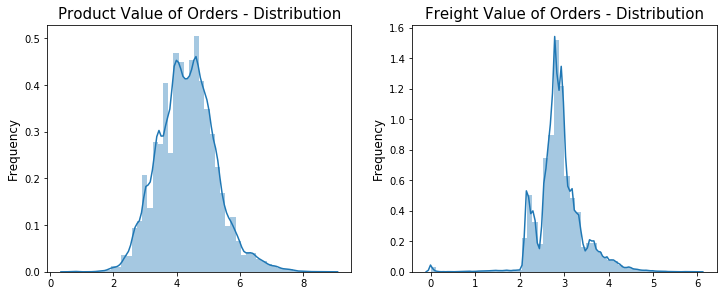

In [37]:
plt.figure(figsize=(12,10))

plt.subplot(221)
g = sns.distplot(df['price'])
g.set_title("Product Value of Orders - Distribution", fontsize=15)
g.set_xlabel("")
g.set_ylabel("Frequency", fontsize=12)

plt.subplot(222)
g1 = sns.distplot(df['freight_value'])
g1.set_title("Freight Value of Orders - Distribution", fontsize=15)
g1.set_xlabel("")
g1.set_ylabel("Frequency", fontsize=12)

In [38]:
df['estimated_delivery_time'] = np.log1p(df['estimated_delivery_time'])
df['actual_delivery_time'] = np.log1p(df['actual_delivery_time'])

Text(0, 0.5, 'Frequency')

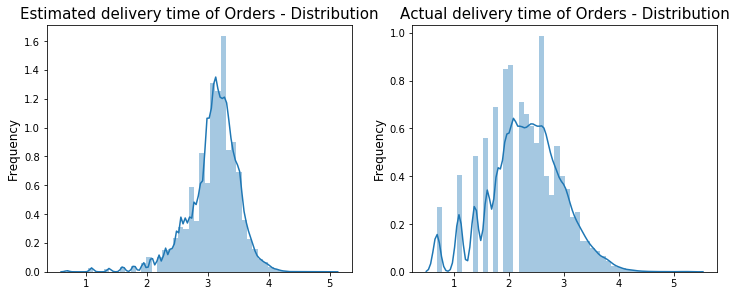

In [39]:
plt.figure(figsize=(12,10))

plt.subplot(221)
g = sns.distplot(df['estimated_delivery_time'])
g.set_title("Estimated delivery time of Orders - Distribution", fontsize=15)
g.set_xlabel("")
g.set_ylabel("Frequency", fontsize=12)

plt.subplot(222)
g1 = sns.distplot(df['actual_delivery_time'])
g1.set_title("Actual delivery time of Orders - Distribution", fontsize=15)
g1.set_xlabel("")
g1.set_ylabel("Frequency", fontsize=12)

In [40]:
print("Skewness: \n",df.skew(),"\n")
print("Kurtosis: \n",df.kurtosis(),"\n")

Skewness: 
 price                         0.295453
freight_value                -0.022774
product_description_lenght    2.006754
product_photos_qty            1.907007
review_score                 -1.327916
estimated_delivery_time      -1.025571
actual_delivery_time         -0.102454
dtype: float64 

Kurtosis: 
 price                         0.446780
freight_value                 5.274028
product_description_lenght    4.910958
product_photos_qty            4.800372
review_score                  0.396432
estimated_delivery_time       2.865996
actual_delivery_time          0.181671
dtype: float64 



In [41]:
X = df.iloc[:,:-1]
y = df['actual_delivery_time']

In [42]:
# turn X into dict
X_dict = X.to_dict(orient='records') # turn each row as key-value pairs
X_dict[0]

{'price': 3.433664571799657,
 'freight_value': 2.2741856184723477,
 'customer_state': 'SP',
 'product_description_lenght': 268.0,
 'product_photos_qty': 4.0,
 'product_category_name': 'housewares',
 'review_score': 4.0,
 'estimated_delivery_time': 2.772588722239781}

In [43]:
# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

dv_X = DictVectorizer(sparse=False) 
# sparse = False means the output is not a sparse matrix
# apply dv_X on X_dict
X_encoded = dv_X.fit_transform(X_dict)
# show X_encoded
X_encoded

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 2.680e+02, 4.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.780e+02, 1.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.320e+02, 1.000e+00,
        5.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.690e+02, 1.000e+00,
        5.000e+00]])

In [44]:
dv_X.vocabulary_

{'price': 29,
 'freight_value': 28,
 'customer_state=SP': 25,
 'product_description_lenght': 101,
 'product_photos_qty': 102,
 'product_category_name=housewares': 79,
 'review_score': 103,
 'estimated_delivery_time': 27,
 'customer_state=BA': 4,
 'product_category_name=perfumery': 89,
 'customer_state=GO': 8,
 'product_category_name=auto': 35,
 'customer_state=RN': 19,
 'product_category_name=pet_shop': 90,
 'product_category_name=stationery': 96,
 'customer_state=PR': 17,
 'customer_state=RJ': 18,
 'customer_state=RS': 22,
 'product_category_name=furniture_decor': 69,
 'product_category_name=office_furniture': 87,
 'product_category_name=garden_tools': 72,
 'product_category_name=computers_accessories': 45,
 'customer_state=MG': 10,
 'product_category_name=bed_bath_table': 37,
 'product_category_name=toys': 99,
 'product_category_name=construction_tools_construction': 47,
 'customer_state=SC': 23,
 'product_category_name=telephony': 98,
 'product_category_name=health_beauty': 73,
 'pr

In [45]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X_encoded, y, test_size = 0.3, random_state = 123)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(76291, 104) (32697, 104) (76291,) (32697,)


In [46]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [47]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)
y_pred

array([1.95289255, 2.33919312, 3.33887564, ..., 1.70727131, 2.6809086 ,
       1.87022436])

In [48]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = r2_score(y_test,y_pred)
print("RMSE: ", rmse)
print("Test score: ", score)

RMSE:  0.5068642609449611
Test score:  0.40502518778391905


In [49]:
y_pred_train = regressor.predict(X_train)
y_pred_train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE Train: ", rmse_train)
score_train = r2_score(y_train,y_pred_train)
print("Train score: ", score_train)

RMSE Train:  0.5047516191834609
Train score:  0.4072940598871603


### Above is the R2 Score after Log Transformations

# Data Exploration

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108988 entries, 0 to 111688
Data columns (total 9 columns):
price                         108988 non-null float64
freight_value                 108988 non-null float64
customer_state                108988 non-null object
product_description_lenght    108988 non-null float64
product_photos_qty            108988 non-null float64
product_category_name         108988 non-null object
review_score                  108988 non-null float64
estimated_delivery_time       108988 non-null float64
actual_delivery_time          108988 non-null float64
dtypes: float64(7), object(2)
memory usage: 8.3+ MB


actual_delivery_time          1.000000
estimated_delivery_time       0.525833
freight_value                 0.358403
price                         0.118345
product_description_lenght    0.002618
product_photos_qty           -0.032590
review_score                 -0.254927
Name: actual_delivery_time, dtype: float64


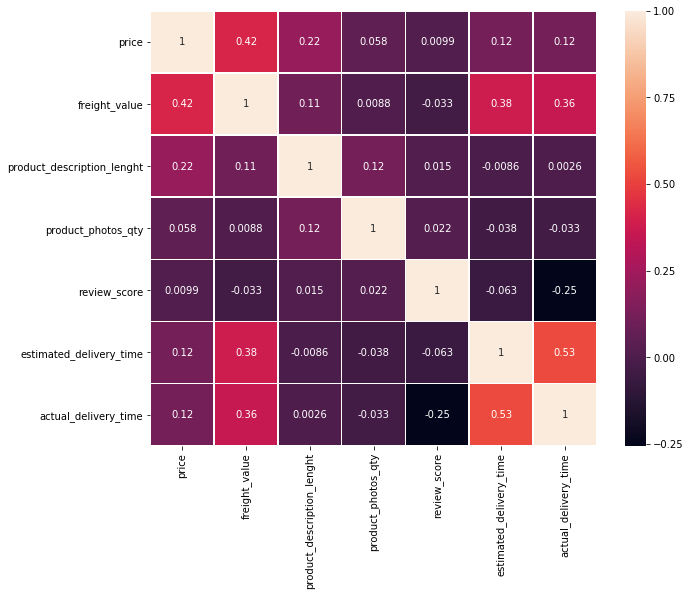

In [51]:
corr_matrix = df.corr()
print(corr_matrix['actual_delivery_time'].sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(10,8))
hm = sns.heatmap(df.corr(), annot = True, linewidths=.5, ax = ax)

## Checking and removing outliers

In [52]:
df_out = df.copy()
df_out.shape

(108988, 9)

### # actual_delivery_time

0.0    0.693147
0.1    1.386294
0.2    1.791759
0.3    1.945910
0.4    2.197225
0.5    2.302585
0.6    2.484907
0.7    2.639057
0.8    2.833213
0.9    3.135494
1.0    5.342334
Name: actual_delivery_time, dtype: float64


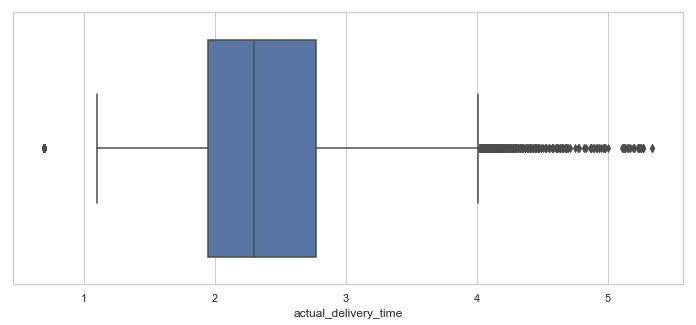

In [53]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,5))
bxpt = sns.boxplot(x= df_out['actual_delivery_time'], ax=ax)

print(df_out['actual_delivery_time'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))

In [54]:
# Function for imputing outliers with lower bound and upper bound

def imputer(data, col_name):
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    lower_bound  = q1-1.5*iqr
    upper_bound = q3+1.5*iqr
    print('Lower bound: ', lower_bound)
    print('Upper bound: ', upper_bound)
    df_out[col_name] = data[col_name].clip(lower_bound, upper_bound)
    return df_out

In [255]:
df_out = imputer(df_out, 'actual_delivery_time')

Lower bound:  0.7058922892786115
Upper bound:  4.012606582016483


In [256]:
print(df_out['actual_delivery_time'].min())
print(df_out['actual_delivery_time'].max())

0.7058922892786115
4.012606582016483


In [257]:
X = df_out.iloc[:,:-1]
y = df_out['actual_delivery_time']

In [258]:
# turn X into dict
X_dict = X.to_dict(orient='records') # turn each row as key-value pairs
X_dict[0]

{'price': 3.433664571799657,
 'freight_value': 2.2741856184723477,
 'customer_state': 'SP',
 'product_description_lenght': 268.0,
 'product_photos_qty': 4.0,
 'product_category_name': 'housewares',
 'review_score': 4.0,
 'estimated_delivery_time': 2.772588722239781}

In [259]:
# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

dv_X = DictVectorizer(sparse=False) 
# sparse = False means the output is not a sparse matrix
# apply dv_X on X_dict
X_encoded = dv_X.fit_transform(X_dict)
# show X_encoded
X_encoded

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 2.680e+02, 4.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.780e+02, 1.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.320e+02, 1.000e+00,
        5.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.690e+02, 1.000e+00,
        5.000e+00]])

In [260]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X_encoded, y, test_size = 0.3, random_state = 123)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(76291, 104) (32697, 104) (76291,) (32697,)


In [261]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [262]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)
y_pred

array([1.95463044, 2.33670265, 3.33004254, ..., 1.708496  , 2.67632653,
       1.8711861 ])

In [263]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = r2_score(y_test,y_pred)
print("RMSE: ", rmse)
print("Test score: ", score)

RMSE:  0.5021333208153579
Test score:  0.4072574862759676


In [264]:
y_pred_train = regressor.predict(X_train)
y_pred_train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE Train: ", rmse_train)

RMSE Train:  0.5005731428357415


#### Checking for outliers again and running the mean imputaion until little or no outliers

#### Mean imputation reduced the score, but also the rmse

No outliers after mean imputation.
We did this because according to our ecommerce knowledge from google, delivery times for all the orders are the same approximately.

0.0    0.705892
0.1    1.386294
0.2    1.791759
0.3    1.945910
0.4    2.197225
0.5    2.302585
0.6    2.484907
0.7    2.639057
0.8    2.833213
0.9    3.135494
1.0    4.012607
Name: actual_delivery_time, dtype: float64


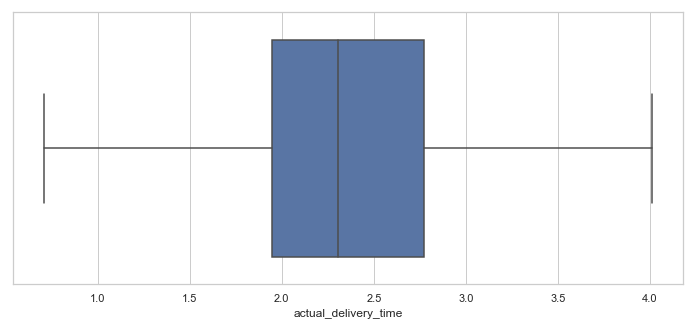

In [265]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,5))
bxpt = sns.boxplot(x= df_out['actual_delivery_time'], ax=ax)

print(df_out['actual_delivery_time'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))

actual_delivery_time          1.000000
estimated_delivery_time       0.527617
freight_value                 0.359450
price                         0.118325
product_description_lenght    0.002578
product_photos_qty           -0.032502
review_score                 -0.254295
Name: actual_delivery_time, dtype: float64


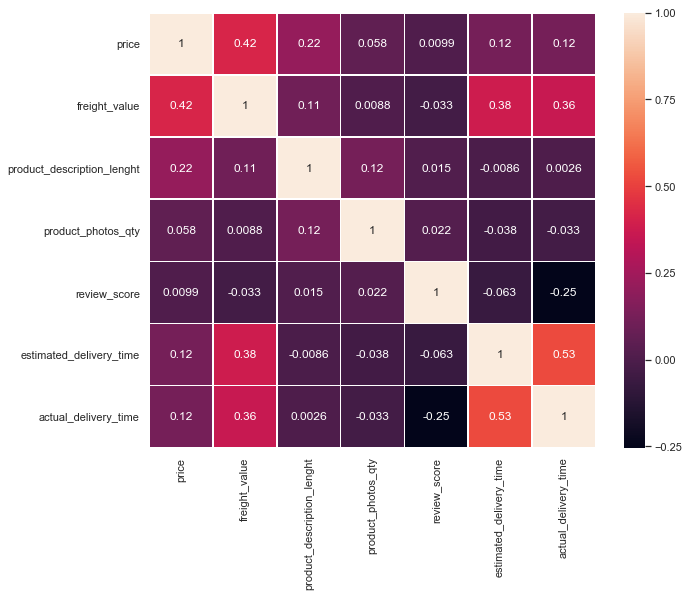

In [266]:
corr_matrix = df_out.corr()
print(corr_matrix['actual_delivery_time'].sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(10,8))
hm = sns.heatmap(corr_matrix, annot = True, linewidths=.5, ax = ax)

### # estimated_delivery_time

0.0    0.693147
0.1    2.564949
0.2    2.833213
0.3    2.995732
0.4    3.091042
0.5    3.135494
0.6    3.218876
0.7    3.295837
0.8    3.401197
0.9    3.555348
1.0    5.036953
Name: estimated_delivery_time, dtype: float64


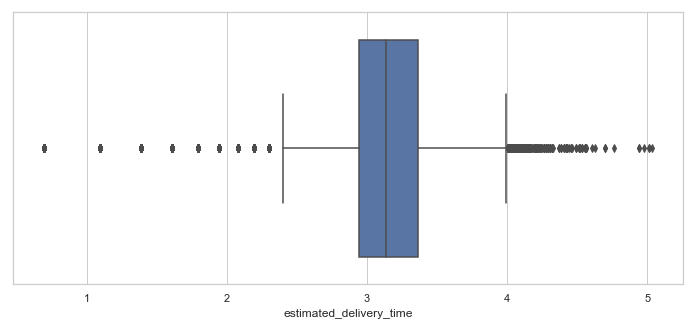

In [267]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,5))
bxpt = sns.boxplot(x= df_out['estimated_delivery_time'], ax=ax)

print(df_out['estimated_delivery_time'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))

In [268]:
# Function for imputing outliers with lower bound and upper bound

def imputer(data, col_name):
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    lower_bound  = q1-1.5*iqr
    upper_bound = q3+1.5*iqr
    print('Lower bound: ', lower_bound)
    print('Upper bound: ', upper_bound)
    df_out[col_name] = data[col_name].clip(lower_bound, upper_bound)
    return df_out

In [269]:
df_out = imputer(df_out, 'estimated_delivery_time')

Lower bound:  2.3101537029363897
Upper bound:  4.001581106216525


In [270]:
print(df_out['estimated_delivery_time'].min())
print(df_out['estimated_delivery_time'].max())

2.3101537029363897
4.001581106216525


In [271]:
X = df_out.iloc[:,:-1]
y = df_out['actual_delivery_time']

In [272]:
# turn X into dict
X_dict = X.to_dict(orient='records') # turn each row as key-value pairs
X_dict[0]

{'price': 3.433664571799657,
 'freight_value': 2.2741856184723477,
 'customer_state': 'SP',
 'product_description_lenght': 268.0,
 'product_photos_qty': 4.0,
 'product_category_name': 'housewares',
 'review_score': 4.0,
 'estimated_delivery_time': 2.772588722239781}

In [273]:
# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

dv_X = DictVectorizer(sparse=False) 
# sparse = False means the output is not a sparse matrix
# apply dv_X on X_dict
X_encoded = dv_X.fit_transform(X_dict)
# show X_encoded
X_encoded

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 2.680e+02, 4.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.780e+02, 1.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.320e+02, 1.000e+00,
        5.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.690e+02, 1.000e+00,
        5.000e+00]])

In [274]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X_encoded, y, test_size = 0.3, random_state = 123)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(76291, 104) (32697, 104) (76291,) (32697,)


In [275]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [276]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)
y_pred

array([1.95519914, 2.31351714, 3.33955749, ..., 1.66352655, 2.67669325,
       1.83352376])

In [277]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = r2_score(y_test,y_pred)
print("RMSE: ", rmse)
print("Test score: ", score)

RMSE:  0.5027399912875103
Test score:  0.40582433457211864


In [278]:
y_pred_train = regressor.predict(X_train)
y_pred_train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE Train: ", rmse_train)

RMSE Train:  0.501096369612207


#### Checking for outliers again and running the mean imputaion again until little or no outliers

#### Mean imputation increased the score and also reduced the rmse

No outliers after mean imputation.
We did this because according to our ecommerce knowledge from google, delivery times for all the orders are the same approximately.

0.0    2.310154
0.1    2.564949
0.2    2.833213
0.3    2.995732
0.4    3.091042
0.5    3.135494
0.6    3.218876
0.7    3.295837
0.8    3.401197
0.9    3.555348
1.0    4.001581
Name: estimated_delivery_time, dtype: float64


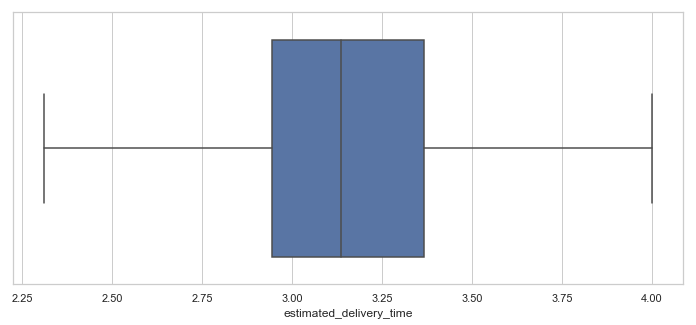

In [279]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,5))
bxpt = sns.boxplot(x= df_out['estimated_delivery_time'], ax=ax)

print(df_out['estimated_delivery_time'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))

actual_delivery_time          1.000000
estimated_delivery_time       0.532550
freight_value                 0.359450
price                         0.118325
product_description_lenght    0.002578
product_photos_qty           -0.032502
review_score                 -0.254295
Name: actual_delivery_time, dtype: float64


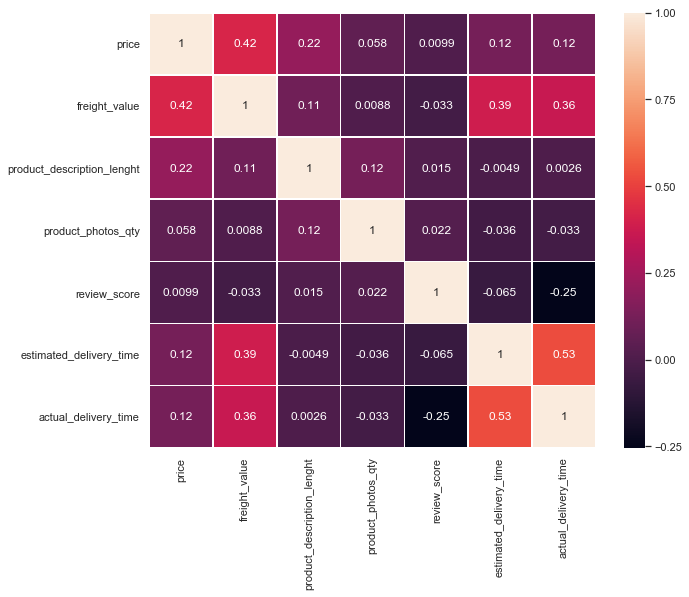

In [280]:
corr_matrix = df_out.corr()
print(corr_matrix['actual_delivery_time'].sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(10,8))
hm = sns.heatmap(corr_matrix, annot=True, linewidths=.5, ax = ax)

### # product_photos_qty

In [281]:
df_out['product_photos_qty'] = df_out['product_photos_qty'].round(0).astype(int)

0.0     1.0
0.1     1.0
0.2     1.0
0.3     1.0
0.4     1.0
0.5     1.0
0.6     2.0
0.7     2.0
0.8     3.0
0.9     5.0
1.0    20.0
Name: product_photos_qty, dtype: float64


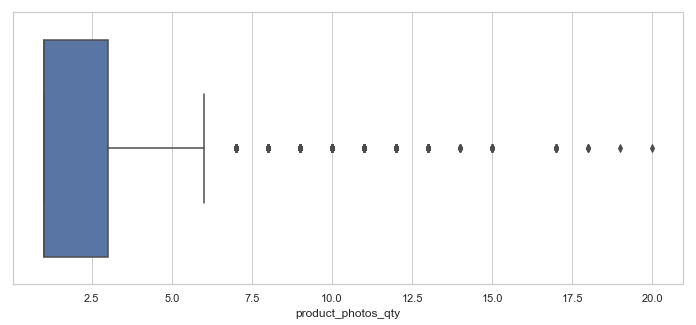

In [282]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,5))
bxpt = sns.boxplot(x= df_out['product_photos_qty'], ax=ax)

print(df_out['product_photos_qty'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))

In [283]:
# Function for imputing outliers with lower bound and upper bound

def imputer(data, col_name):
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    lower_bound  = q1-1.5*iqr
    upper_bound = q3+1.5*iqr
    print('Lower bound: ', lower_bound)
    print('Upper bound: ', upper_bound)
    df_out[col_name] = data[col_name].clip(round(lower_bound), round(upper_bound))
    return df_out

In [284]:
df_out = imputer(df_out, 'product_photos_qty')

Lower bound:  -2.0
Upper bound:  6.0


In [285]:
print(df_out['product_photos_qty'].min())
print(df_out['product_photos_qty'].max())

1
6


In [286]:
X = df_out.iloc[:,:-1]
y = df_out['actual_delivery_time']

In [287]:
# turn X into dict
X_dict = X.to_dict(orient='records') # turn each row as key-value pairs
X_dict[0]

{'price': 3.433664571799657,
 'freight_value': 2.2741856184723477,
 'customer_state': 'SP',
 'product_description_lenght': 268.0,
 'product_photos_qty': 4,
 'product_category_name': 'housewares',
 'review_score': 4.0,
 'estimated_delivery_time': 2.772588722239781}

In [288]:
# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

dv_X = DictVectorizer(sparse=False) 
# sparse = False means the output is not a sparse matrix
# apply dv_X on X_dict
X_encoded = dv_X.fit_transform(X_dict)
# show X_encoded
X_encoded

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 2.680e+02, 4.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.780e+02, 1.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.320e+02, 1.000e+00,
        5.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.690e+02, 1.000e+00,
        5.000e+00]])

In [289]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X_encoded, y, test_size = 0.3, random_state = 123)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(76291, 104) (32697, 104) (76291,) (32697,)


In [290]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [291]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)
y_pred

array([1.95627086, 2.31623847, 3.3395776 , ..., 1.66159366, 2.67802441,
       1.83736609])

In [292]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = r2_score(y_test,y_pred)
print("RMSE: ", rmse)
print("Test score: ", score)

RMSE:  0.5027082997923347
Test score:  0.40589924296234914


In [293]:
y_pred_train = regressor.predict(X_train)
y_pred_train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE Train: ", rmse_train)

RMSE Train:  0.5010379976115916


#### Checking for outliers again and running the mean imputaion again until little or no outliers

#### Mean imputation increased the score and reduced rmse

No outliers after mean imputation.

0.0    1.0
0.1    1.0
0.2    1.0
0.3    1.0
0.4    1.0
0.5    1.0
0.6    2.0
0.7    2.0
0.8    3.0
0.9    5.0
1.0    6.0
Name: product_photos_qty, dtype: float64


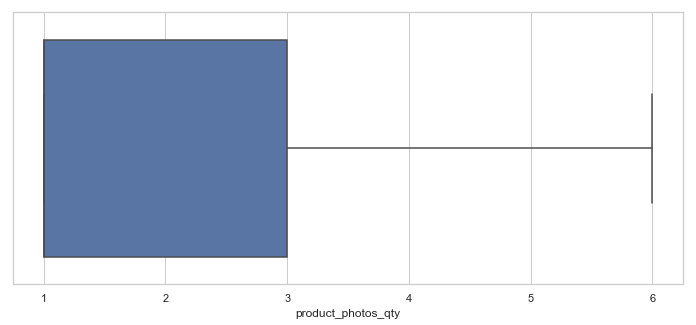

In [294]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,5))
bxpt = sns.boxplot(x= df_out['product_photos_qty'], ax=ax)

print(df_out['product_photos_qty'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))

actual_delivery_time          1.000000
estimated_delivery_time       0.532550
freight_value                 0.359450
price                         0.118325
product_description_lenght    0.002578
product_photos_qty           -0.036411
review_score                 -0.254295
Name: actual_delivery_time, dtype: float64


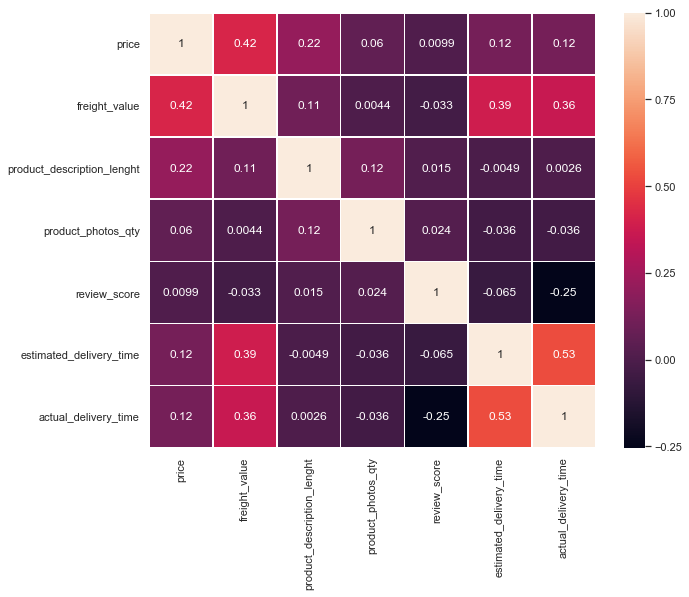

In [295]:
corr_matrix = df_out.corr()
print(corr_matrix['actual_delivery_time'].sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(10,8))
hm = sns.heatmap(corr_matrix, annot=True, linewidths=.5, ax = ax)

### # freight_value

0.00    0.000000
0.10    2.282382
0.20    2.577942
0.30    2.711378
0.40    2.779440
0.50    2.850707
0.60    2.938103
0.70    3.017004
0.80    3.190065
0.90    3.556490
0.95    3.831030
1.00    6.017814
Name: freight_value, dtype: float64


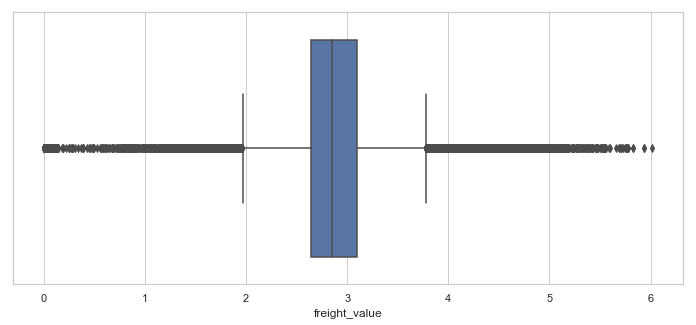

In [296]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,5))
bxpt = sns.boxplot(x= df_out['freight_value'], ax=ax)

print(df_out['freight_value'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1]))

In [297]:
def remove_outlier(data, col_name):
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    lower_bound  = q1-1.5*iqr
    upper_bound = q3+1.5*iqr
    df_out = data.loc[(data[col_name] > lower_bound) & (data[col_name] < upper_bound)]
    return df_out

In [224]:
#4 TIMES

df_out =  remove_outlier(df_out, 'freight_value')
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96293 entries, 0 to 111688
Data columns (total 9 columns):
price                         96293 non-null float64
freight_value                 96293 non-null float64
customer_state                96293 non-null object
product_description_lenght    96293 non-null float64
product_photos_qty            96293 non-null float64
product_category_name         96293 non-null object
review_score                  96293 non-null float64
estimated_delivery_time       96293 non-null float64
actual_delivery_time          96293 non-null float64
dtypes: float64(7), object(2)
memory usage: 7.3+ MB


In [225]:
X = df_out.iloc[:,:-1]
y = df_out['actual_delivery_time']

In [226]:
# turn X into dict
X_dict = X.to_dict(orient='records') # turn each row as key-value pairs
X_dict[0]

{'price': 3.433664571799657,
 'freight_value': 2.2741856184723477,
 'customer_state': 'SP',
 'product_description_lenght': 268.0,
 'product_photos_qty': 4.0,
 'product_category_name': 'housewares',
 'review_score': 4.0,
 'estimated_delivery_time': 2.772588722239781}

In [227]:
# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

dv_X = DictVectorizer(sparse=False) 
# sparse = False means the output is not a sparse matrix
# apply dv_X on X_dict
X_encoded = dv_X.fit_transform(X_dict)
# show X_encoded
X_encoded

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 2.680e+02, 4.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.780e+02, 1.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.320e+02, 1.000e+00,
        5.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.517e+03, 1.000e+00,
        5.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 8.280e+02, 4.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.690e+02, 1.000e+00,
        5.000e+00]])

In [228]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X_encoded, y, test_size = 0.3, random_state = 123)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(67405, 104) (28888, 104) (67405,) (28888,)


In [229]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [230]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)
y_pred

array([2.27889819, 2.31830861, 2.96465111, ..., 2.52617501, 2.3235344 ,
       2.26733637])

In [231]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = r2_score(y_test,y_pred)
print("RMSE: ", rmse)
print("Test score: ", score)

RMSE:  0.5013879339330463
Test score:  0.4008065764683102


In [232]:
y_pred_train = regressor.predict(X_train)
y_pred_train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE Train: ", rmse_train)

RMSE Train:  0.49980935468455656


#### Checking for outliers again and running the remove outlier function again until little or no outliers

#### Deleting outliers increased the score and reduced rmse

No outliers after above transformation.

0.0    2.079442
0.1    2.290513
0.2    2.557227
0.3    2.683074
0.4    2.778819
0.5    2.818995
0.6    2.888704
0.7    2.956472
0.8    3.043093
0.9    3.203965
1.0    3.538638
Name: freight_value, dtype: float64


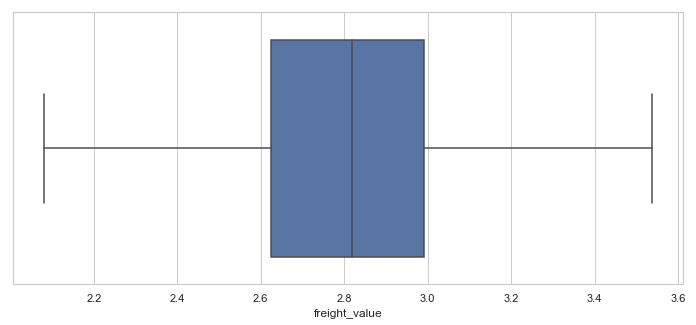

In [233]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,5))
bxpt = sns.boxplot(x= df_out['freight_value'], ax=ax)

print(df_out['freight_value'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))

actual_delivery_time          1.000000
estimated_delivery_time       0.532550
freight_value                 0.359450
price                         0.118325
product_description_lenght    0.002578
product_photos_qty           -0.036411
review_score                 -0.254295
Name: actual_delivery_time, dtype: float64


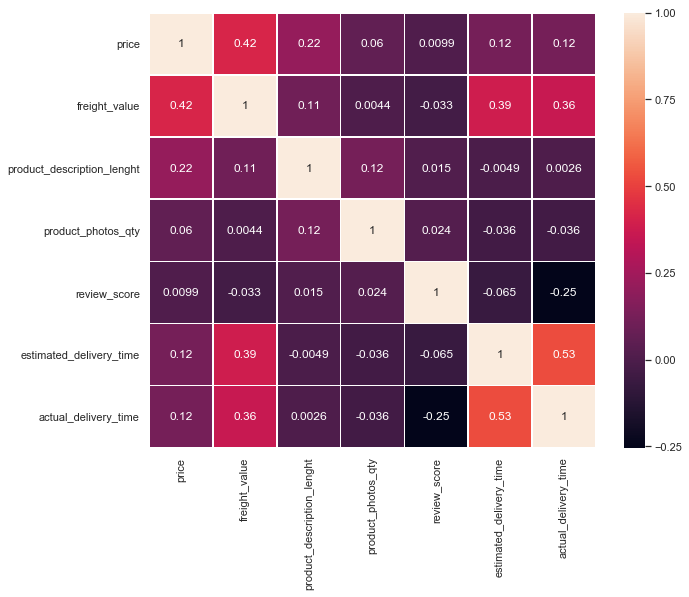

In [298]:
corr_matrix = df_out.corr()
print(corr_matrix['actual_delivery_time'].sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(10,8))
hm = sns.heatmap(corr_matrix, annot=True, linewidths=.5, ax = ax)

### # price

0.0    0.615186
0.1    3.214868
0.2    3.580737
0.3    3.881564
0.4    4.094345
0.5    4.329417
0.6    4.563306
0.7    4.787492
0.8    5.017280
0.9    5.438079
1.0    8.815222
Name: price, dtype: float64


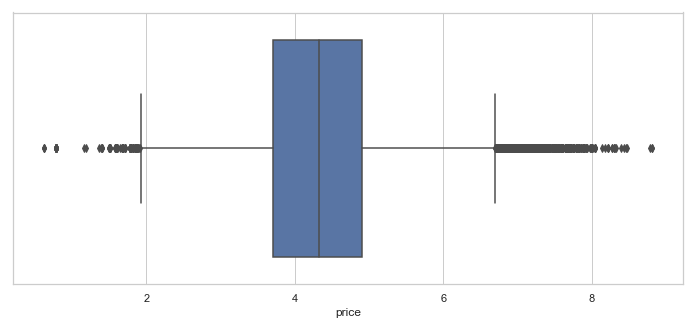

In [299]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,5))
bxpt = sns.boxplot(x= df_out['price'], ax=ax)

print(df_out['price'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))

actual_delivery_time          1.000000
freight_value                 0.358505
estimated_delivery_time       0.345345
product_photos_qty            0.136307
price                        -0.043415
product_description_lenght   -0.141127
review_score                 -0.238026
Name: actual_delivery_time, dtype: float64


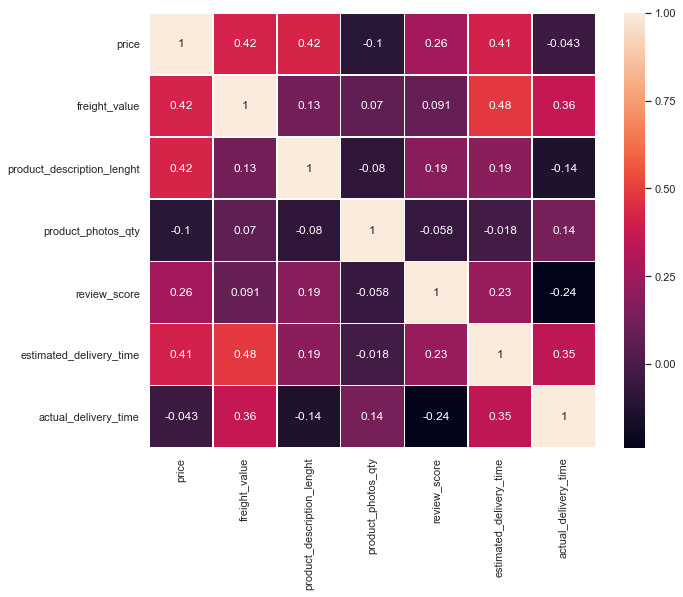

In [172]:
corr_matrix = df_out.corr()
print(corr_matrix['actual_delivery_time'].sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(10,8))
hm = sns.heatmap(corr_matrix, annot=True, linewidths=.5, ax = ax)

### # product_description_lenght

In [300]:
df_out['product_description_lenght'] = df_out['product_description_lenght'].round(0).astype(int)

0.0       4.0
0.1     215.0
0.2     307.0
0.3     390.0
0.4     493.0
0.5     601.0
0.6     734.0
0.7     897.0
0.8    1127.0
0.9    1584.0
1.0    3992.0
Name: product_description_lenght, dtype: float64


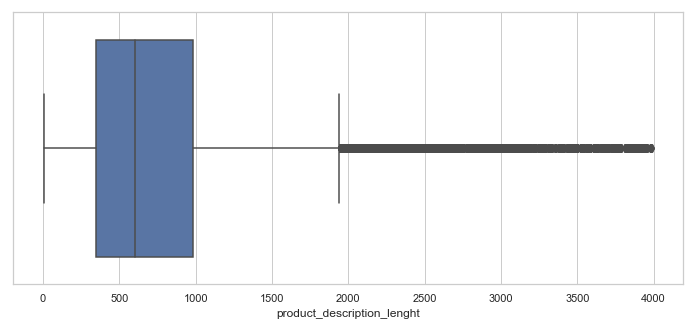

In [301]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,5))
bxpt = sns.boxplot(x= df_out['product_description_lenght'], ax=ax)

print(df_out['product_description_lenght'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))

In [302]:
# Function for imputing outliers with lower bound and upper bound

def imputer(data, col_name):
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    lower_bound  = q1-1.5*iqr
    upper_bound = q3+1.5*iqr
    print('Lower bound: ', lower_bound)
    print('Upper bound: ', upper_bound)
    df_out[col_name] = data[col_name].clip(round(lower_bound), round(upper_bound))
    return df_out

In [303]:
df_out =  imputer(df_out, 'product_description_lenght')

Lower bound:  -610.0
Upper bound:  1942.0


In [304]:
print(df_out['product_description_lenght'].min())
print(df_out['product_description_lenght'].max())

4
1942


In [305]:
X = df_out.iloc[:,:-1]
y = df_out['actual_delivery_time']

In [306]:
# turn X into dict
X_dict = X.to_dict(orient='records') # turn each row as key-value pairs
X_dict[0]

{'price': 3.433664571799657,
 'freight_value': 2.2741856184723477,
 'customer_state': 'SP',
 'product_description_lenght': 268,
 'product_photos_qty': 4,
 'product_category_name': 'housewares',
 'review_score': 4.0,
 'estimated_delivery_time': 2.772588722239781}

In [307]:
# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

dv_X = DictVectorizer(sparse=False) 
# sparse = False makes the output is not a sparse matrix
# apply dv_X on X_dict
X_encoded = dv_X.fit_transform(X_dict)
# show X_encoded
X_encoded

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 2.680e+02, 4.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.780e+02, 1.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.320e+02, 1.000e+00,
        5.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.690e+02, 1.000e+00,
        5.000e+00]])

In [308]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X_encoded, y, test_size = 0.3, random_state = 123)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(76291, 104) (32697, 104) (76291,) (32697,)


In [309]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [310]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)
y_pred

array([1.95744113, 2.31201799, 3.34156861, ..., 1.66228364, 2.6791603 ,
       1.83689575])

In [311]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = r2_score(y_test,y_pred)
print("RMSE: ", rmse)
print("Test score: ", score)

RMSE:  0.5026948081455004
Test score:  0.4059311313956333


In [312]:
y_pred_train = regressor.predict(X_train)
y_pred_train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE Train: ", rmse_train)

RMSE Train:  0.5010213156050175


#### Imputing outliers with mean overfits the line, Hence, we got the score of 0.99

#### Checking for outliers again and running the remove outlier function until little or no outliers left

#### Deleting outliers increased the score and reduced rmse

Very little outliers left after above transformation.

0.0       4.0
0.1     215.0
0.2     307.0
0.3     390.0
0.4     493.0
0.5     601.0
0.6     734.0
0.7     897.0
0.8    1127.0
0.9    1584.0
1.0    1942.0
Name: product_description_lenght, dtype: float64


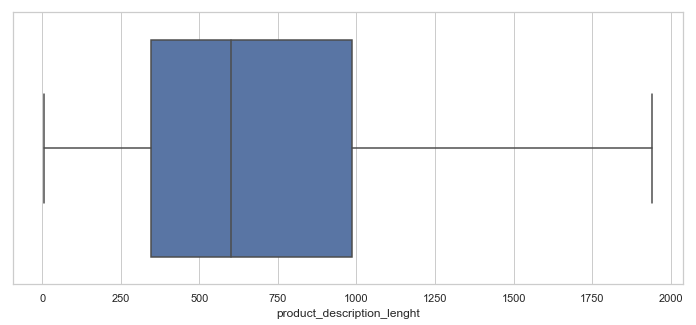

In [313]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,5))
bxpt = sns.boxplot(x= df_out['product_description_lenght'], ax=ax)

print(df_out['product_description_lenght'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))

### # review_score

In [314]:
df_out['product_description_lenght'] = df_out['product_description_lenght'].round(0).astype(int)

0.0    1.0
0.1    1.0
0.2    3.0
0.3    4.0
0.4    4.0
0.5    5.0
0.6    5.0
0.7    5.0
0.8    5.0
0.9    5.0
1.0    5.0
Name: review_score, dtype: float64


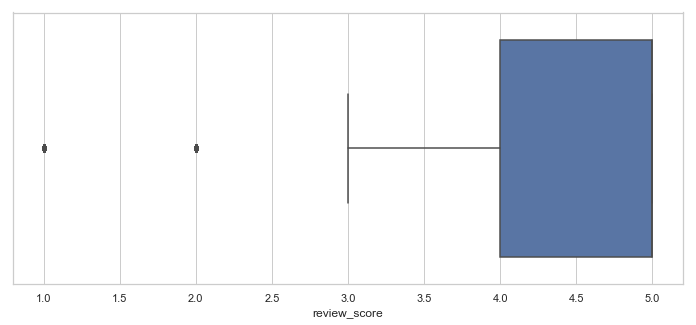

In [315]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,5))
bxpt = sns.boxplot(x= df_out['review_score'], ax=ax)

print(df_out['review_score'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))

In [319]:
# Function for imputing outliers with lower bound and upper bound

def imputer(data, col_name):
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    lower_bound  = q1-1.5*iqr
    upper_bound = q3+1.5*iqr
    print('Lower bound: ', lower_bound)
    print('Upper bound: ', upper_bound)
    df_out[col_name] = data[col_name].clip(round(lower_bound), round(upper_bound))
    return df_out

In [332]:
df_out =  imputer(df_out, 'review_score')

Lower bound:  2.5
Upper bound:  6.5


In [333]:
print(df_out['review_score'].min())
print(df_out['review_score'].max())

2.0
5.0


In [334]:
X = df_out.iloc[:,:-1]
y = df_out['actual_delivery_time']

In [335]:
# turn X into dict
X_dict = X.to_dict(orient='records') # turn each row as key-value pairs
X_dict[0]

{'price': 3.433664571799657,
 'freight_value': 2.2741856184723477,
 'customer_state': 'SP',
 'product_description_lenght': 268,
 'product_photos_qty': 4,
 'product_category_name': 'housewares',
 'review_score': 4.0,
 'estimated_delivery_time': 2.772588722239781}

In [336]:
# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

dv_X = DictVectorizer(sparse=False) 
# sparse = False makes the output is not a sparse matrix
# apply dv_X on X_dict
X_encoded = dv_X.fit_transform(X_dict)
# show X_encoded
X_encoded

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 2.680e+02, 4.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.780e+02, 1.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.320e+02, 1.000e+00,
        5.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.690e+02, 1.000e+00,
        5.000e+00]])

In [337]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X_encoded, y, test_size = 0.3, random_state = 123)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(76291, 104) (32697, 104) (76291,) (32697,)


In [338]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [339]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)
y_pred

array([1.95209048, 2.31013757, 3.29754222, ..., 1.65795616, 2.63660569,
       1.85139558])

In [340]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = r2_score(y_test,y_pred)
print("RMSE: ", rmse)
print("Test score: ", score)

RMSE:  0.5033625404351271
Test score:  0.404351873305724


In [341]:
y_pred_train = regressor.predict(X_train)
y_pred_train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE Train: ", rmse_train)

RMSE Train:  0.5018851506575541


#### Checking for outliers again and running the remove outlier function until little or no outliers left

#### Deleting outliers increased the score and reduced rmse

Very little outliers left after above transformation.

0.0    2.0
0.1    2.0
0.2    3.0
0.3    4.0
0.4    4.0
0.5    5.0
0.6    5.0
0.7    5.0
0.8    5.0
0.9    5.0
1.0    5.0
Name: review_score, dtype: float64


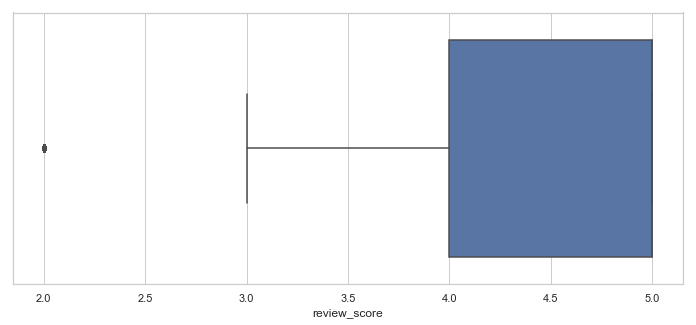

In [342]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,5))
bxpt = sns.boxplot(x= df_out['review_score'], ax=ax)

print(df_out['review_score'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))

#### There are no outliers in this feature

In [343]:
print("RMSE: ", rmse)
print("Test score: ", score)

RMSE:  0.5033625404351271
Test score:  0.404351873305724


In [344]:
y_pred_train = regressor.predict(X_train)
y_pred_train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE Train: ", rmse_train)

RMSE Train:  0.5018851506575541


***********************************************************************************************************************************************

# Feature Engineering

#### Aggregating categories into higher-level categories.

In [345]:
fe = df_out.copy()

In [346]:
# Dividing customer state into 5 regions of Brazil

north = ['AC','AP','AM','PA','RO','RR','TO']
north_east = ['AL','BA','CE','MA','PB','PE','PI','RN','SE']
center_west = ['DF','GO','MT','MS']
south_east = ['ES','MG','RJ','SP']
south = ['PR','RS','SC']


In [347]:
fe.loc[fe['customer_state'].isin(north), 'customer_regions'] = 'north'
fe.loc[fe['customer_state'].isin(north_east), 'customer_regions'] = 'north_east'
fe.loc[fe['customer_state'].isin(center_west), 'customer_regions'] = 'center_west'
fe.loc[fe['customer_state'].isin(south_east), 'customer_regions'] = 'south_east'
fe.loc[fe['customer_state'].isin(south), 'customer_regions'] = 'south'

In [348]:
fe = fe.reset_index(drop=True)
fe.head()

,price,freight_value,customer_state,product_description_lenght,product_photos_qty,product_category_name,review_score,estimated_delivery_time,actual_delivery_time,customer_regions
0,3.433665,2.274186,SP,268,4,housewares,4.0,2.772589,2.197225,south_east
1,4.784989,3.168003,BA,178,1,perfumery,4.0,2.890372,2.564949,north_east
2,5.080783,3.006672,GO,232,1,auto,5.0,3.295837,2.302585,center_west
3,3.828641,3.339322,RN,468,3,pet_shop,5.0,3.295837,2.639057,north_east
4,3.039749,2.274186,SP,316,4,stationery,5.0,2.564949,1.098612,south_east


In [258]:
# Dividing product_category_name into category types

In [349]:
home_personal = ['bed_bath_table', 'housewares', 'food_drink', 'kitchen_dining_laundry_garden_furniture', 'home_confort', 'home_comfort_2', 
                 'food', 'christmas_supplies', 'drinks', 'health_beauty', 'bed_bath_table', 'perfumery', 'watches_gifts', 'flowers', 
                 'party_supplies', 'auto', 'pet_shop', 'cine_photo', 'la_cuisine']

entertainment_stationary = ['audio', 'books_technical', 'musical_instruments', 'books_general_interest', 'art', 'books_imported', 'music',
                              'arts_and_craftmanship', 'stationery', 'consoles_games', 'cool_stuff']

electronics_furniture = ['computers_accessories', 'furniture_decor', 'telephony', 'tablets_printing_image', 'fixed_telephony', 
                         'small_appliances', 'air_conditioning', 'office_furniture', 'electronics', 'home_appliances',
                         'furniture_living_room', 'home_construction', 'furniture_mattress_and_upholstery', 'furniture_bedroom',
                         'signaling_and_security', 'computers', 'home_appliances_2', 'small_appliances_home_oven_and_coffee', 
                         'cds_dvds_musicals', 'dvds_blu_ray', 'security_and_services']

garden_construction_idustry = ['garden_tools', 'construction_tools_construction', 'costruction_tools_garden', 'costruction_tools_tools',
                               'construction_tools_lights', 'construction_tools_safety', 'market_place',  'agro_industry_and_commerce',  
                               'industry_commerce_and_business',]

fashion_baby_accessories = ['sports_leisure', 'baby', 'toys', 'fashion_bags_accessories', 'fashion_shoes', 'luggage_accessories',
                            'fashion_male_clothing', 'fashion_underwear_beach', 'fashion_sport', 'fashio_female_clothing',
                            'diapers_and_hygiene', 'fashion_childrens_clothes']


In [350]:
fe.loc[fe['product_category_name'].isin(home_personal), 'product_category_type'] = 'home_personal'
fe.loc[fe['product_category_name'].isin(entertainment_stationary), 'product_category_type'] = 'entertainment_stationary'
fe.loc[fe['product_category_name'].isin(electronics_furniture), 'product_category_type'] = 'electronics_furniture'
fe.loc[fe['product_category_name'].isin(garden_construction_idustry), 'product_category_type'] = 'garden_construction_idustry'
fe.loc[fe['product_category_name'].isin(fashion_baby_accessories), 'product_category_type'] = 'fashion_baby_accessories'

In [351]:
fe.head()

,price,freight_value,customer_state,product_description_lenght,product_photos_qty,product_category_name,review_score,estimated_delivery_time,actual_delivery_time,customer_regions,product_category_type
0,3.433665,2.274186,SP,268,4,housewares,4.0,2.772589,2.197225,south_east,home_personal
1,4.784989,3.168003,BA,178,1,perfumery,4.0,2.890372,2.564949,north_east,home_personal
2,5.080783,3.006672,GO,232,1,auto,5.0,3.295837,2.302585,center_west,home_personal
3,3.828641,3.339322,RN,468,3,pet_shop,5.0,3.295837,2.639057,north_east,home_personal
4,3.039749,2.274186,SP,316,4,stationery,5.0,2.564949,1.098612,south_east,entertainment_stationary


In [352]:
fe['product_category_type'].value_counts()

home_personal                  44789
electronics_furniture          28822
fashion_baby_accessories       19197
entertainment_stationary        9397
garden_construction_idustry     6783
Name: product_category_type, dtype: int64

In [353]:
# Lets remove the columns that we have aggregated from: customer_state and product_category_name

fe = fe.drop(['customer_state','product_category_name'], axis=1)
fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108988 entries, 0 to 108987
Data columns (total 9 columns):
price                         108988 non-null float64
freight_value                 108988 non-null float64
product_description_lenght    108988 non-null int32
product_photos_qty            108988 non-null int32
review_score                  108988 non-null float64
estimated_delivery_time       108988 non-null float64
actual_delivery_time          108988 non-null float64
customer_regions              108988 non-null object
product_category_type         108988 non-null object
dtypes: float64(5), int32(2), object(2)
memory usage: 6.7+ MB


In [354]:
target = ['actual_delivery_time']
fe = fe[[c for c in fe if c not in target] + [c for c in target if c in fe]]
fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108988 entries, 0 to 108987
Data columns (total 9 columns):
price                         108988 non-null float64
freight_value                 108988 non-null float64
product_description_lenght    108988 non-null int32
product_photos_qty            108988 non-null int32
review_score                  108988 non-null float64
estimated_delivery_time       108988 non-null float64
customer_regions              108988 non-null object
product_category_type         108988 non-null object
actual_delivery_time          108988 non-null float64
dtypes: float64(5), int32(2), object(2)
memory usage: 6.7+ MB


In [355]:
fe = fe.dropna(axis=1)
fe.isnull().sum()

price                         0
freight_value                 0
product_description_lenght    0
product_photos_qty            0
review_score                  0
estimated_delivery_time       0
customer_regions              0
product_category_type         0
actual_delivery_time          0
dtype: int64

actual_delivery_time          1.000000
estimated_delivery_time       0.532550
freight_value                 0.359450
price                         0.118325
product_description_lenght    0.004708
product_photos_qty           -0.036411
review_score                 -0.249745
Name: actual_delivery_time, dtype: float64


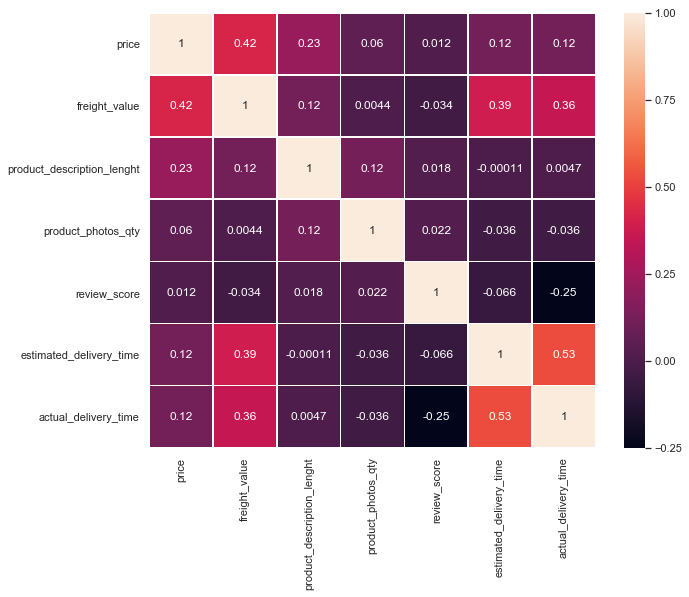

In [356]:
corr_matrix = fe.corr()
print(corr_matrix['actual_delivery_time'].sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(10,8))
hm = sns.heatmap(corr_matrix, annot=True, linewidths=.5, ax = ax)

In [357]:
X = fe.iloc[:,:-1]
y = fe['actual_delivery_time']

In [358]:
# turn X into dict
X_dict = X.to_dict(orient='records') # turn each row as key-value pairs
X_dict[0]

{'price': 3.433664571799657,
 'freight_value': 2.2741856184723477,
 'product_description_lenght': 268,
 'product_photos_qty': 4,
 'review_score': 4.0,
 'estimated_delivery_time': 2.772588722239781,
 'customer_regions': 'south_east',
 'product_category_type': 'home_personal'}

In [359]:
# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

dv_X = DictVectorizer(sparse=False) 
# sparse = False means the output is not a sparse matrix
# apply dv_X on X_dict
X_encoded = dv_X.fit_transform(X_dict)
# show X_encoded
X_encoded

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 2.680e+02, 4.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 1.000e+00, ..., 1.780e+02, 1.000e+00,
        4.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00, ..., 2.320e+02, 1.000e+00,
        5.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.690e+02, 1.000e+00,
        5.000e+00]])

In [360]:
dv_X.vocabulary_

{'price': 7,
 'freight_value': 6,
 'product_description_lenght': 13,
 'product_photos_qty': 14,
 'review_score': 15,
 'estimated_delivery_time': 5,
 'customer_regions=south_east': 4,
 'product_category_type=home_personal': 12,
 'customer_regions=north_east': 2,
 'customer_regions=center_west': 0,
 'product_category_type=entertainment_stationary': 9,
 'customer_regions=south': 3,
 'product_category_type=electronics_furniture': 8,
 'product_category_type=garden_construction_idustry': 11,
 'product_category_type=fashion_baby_accessories': 10,
 'customer_regions=north': 1}

In [361]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X_encoded, y, test_size = 0.3, random_state = 123)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(76291, 16) (32697, 16) (76291,) (32697,)


In [362]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [363]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)
y_pred

array([2.12840744, 2.29182526, 3.05061406, ..., 1.68238633, 2.44948431,
       1.88187362])

In [364]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = r2_score(y_test,y_pred)
print("RMSE: ", rmse)
print("Test score: ", score)

RMSE:  0.5137530110259774
Test score:  0.37950718762135627


In [365]:
y_pred_train = regressor.predict(X_train)
y_pred_train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE Train: ", rmse_train)

RMSE Train:  0.5137846620441295


##### The score actually decreases after this and rmse increases

#### Adding a total_order_value feature

In [366]:
tv = df_out.copy()

In [367]:
# Calculating total order value
tv['total_order_value'] = tv.price + tv.freight_value

Text(0, 0.5, 'Frequency')

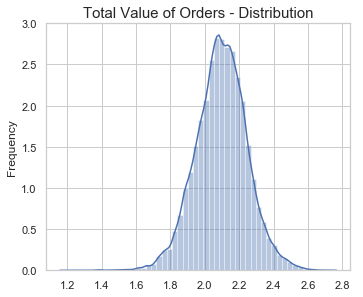

In [369]:
plt.figure(figsize=(12,10))

plt.subplot(221)
g = sns.distplot(np.log1p(tv['total_order_value']))
g.set_title("Total Value of Orders - Distribution", fontsize=15)
g.set_xlabel("")
g.set_ylabel("Frequency", fontsize=12)

In [370]:
tv['total_order_value'] = np.log1p(tv['total_order_value'])

In [371]:
tv = tv.drop(['price','freight_value'], axis=1)

In [372]:
target = ['actual_delivery_time']
tv = tv[[c for c in tv if c not in target] + [c for c in target if c in tv]]
tv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108988 entries, 0 to 111688
Data columns (total 8 columns):
customer_state                108988 non-null object
product_description_lenght    108988 non-null int32
product_photos_qty            108988 non-null int32
product_category_name         108988 non-null object
review_score                  108988 non-null float64
estimated_delivery_time       108988 non-null float64
total_order_value             108988 non-null float64
actual_delivery_time          108988 non-null float64
dtypes: float64(4), int32(2), object(2)
memory usage: 6.7+ MB


actual_delivery_time          1.000000
estimated_delivery_time       0.532550
total_order_value             0.248319
product_description_lenght    0.004708
product_photos_qty           -0.036411
review_score                 -0.249745
Name: actual_delivery_time, dtype: float64


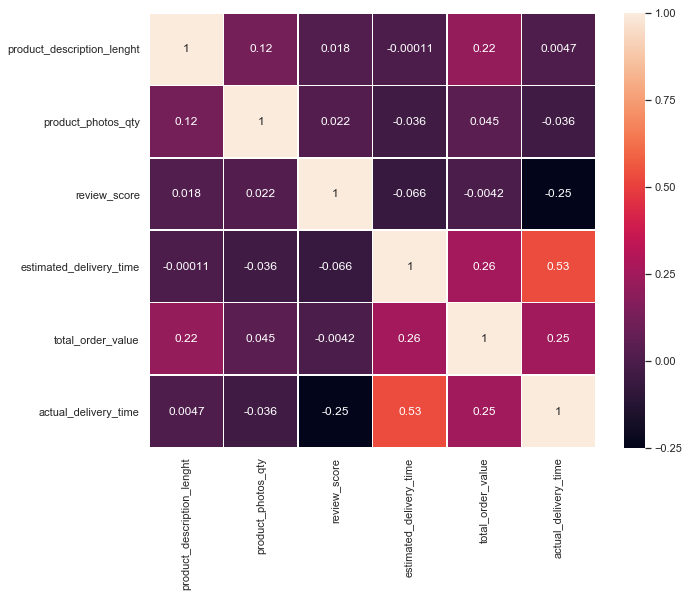

In [373]:
corr_matrix = tv.corr()
print(corr_matrix['actual_delivery_time'].sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(10,8))
hm = sns.heatmap(corr_matrix, annot=True, linewidths=.5, ax = ax)

In [374]:
X = tv.iloc[:,:-1]
y = tv['actual_delivery_time']

In [375]:
# turn X into dict
X_dict = X.to_dict(orient='records') # turn each row as key-value pairs
X_dict[0]

{'customer_state': 'SP',
 'product_description_lenght': 268,
 'product_photos_qty': 4,
 'product_category_name': 'housewares',
 'review_score': 4.0,
 'estimated_delivery_time': 2.772588722239781,
 'total_order_value': 1.9032785107169448}

In [376]:
# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

dv_X = DictVectorizer(sparse=False) 
# sparse = False means the output is not a sparse matrix
# apply dv_X on X_dict
X_encoded = dv_X.fit_transform(X_dict)
# show X_encoded
X_encoded

array([[0.        , 0.        , 0.        , ..., 4.        , 4.        ,
        1.90327851],
       [0.        , 0.        , 0.        , ..., 1.        , 4.        ,
        2.19198779],
       [0.        , 0.        , 0.        , ..., 1.        , 5.        ,
        2.20689492],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 2.        ,
        2.29518795],
       [0.        , 0.        , 0.        , ..., 1.        , 2.        ,
        2.29518795],
       [0.        , 0.        , 0.        , ..., 1.        , 5.        ,
        2.10468715]])

In [377]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X_encoded, y, test_size = 0.3, random_state = 123)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(76291, 103) (32697, 103) (76291,) (32697,)


In [378]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [379]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)
y_pred

array([1.90942807, 2.36704098, 3.28385417, ..., 1.6746181 , 2.73516692,
       1.80031706])

In [380]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = r2_score(y_test,y_pred)
print("RMSE: ", rmse)
print("Test score: ", score)

RMSE:  0.5046170470732659
Test score:  0.4013791622677736


In [381]:
y_pred_train = regressor.predict(X_train)
y_pred_train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE Train: ", rmse_train)

RMSE Train:  0.5028762043726758


##### The score decreases after this and rmse increases

### Working on our previous dataset again: df_out

actual_delivery_time          1.000000
estimated_delivery_time       0.532550
freight_value                 0.359450
price                         0.118325
product_description_lenght    0.004708
product_photos_qty           -0.036411
review_score                 -0.249745
Name: actual_delivery_time, dtype: float64


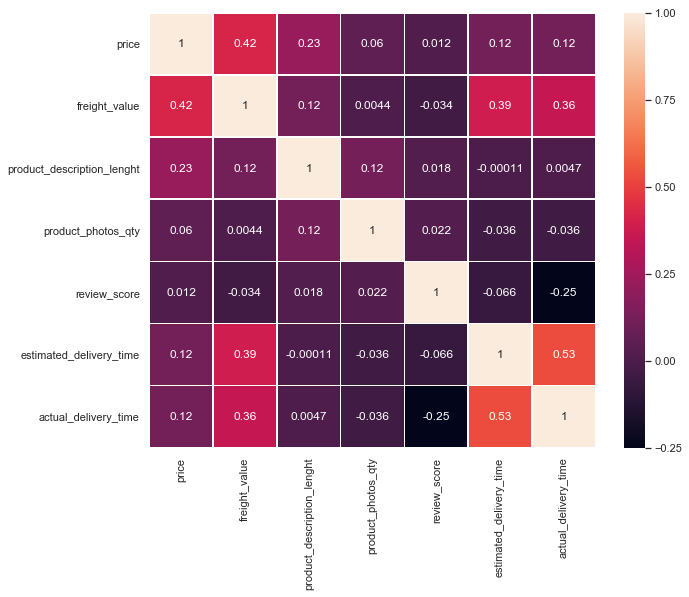

In [382]:
corr_matrix = df_out.corr()
print(corr_matrix['actual_delivery_time'].sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(10,8))
hm = sns.heatmap(corr_matrix, annot = True, linewidths=.5, ax = ax)

In [384]:
X = df_out.iloc[:,:-1]
y = df_out['actual_delivery_time']

In [385]:
# turn X into dict
X_dict = X.to_dict(orient='records') # turn each row as key-value pairs
X_dict[0]

{'price': 3.433664571799657,
 'freight_value': 2.2741856184723477,
 'customer_state': 'SP',
 'product_description_lenght': 268,
 'product_photos_qty': 4,
 'product_category_name': 'housewares',
 'review_score': 4.0,
 'estimated_delivery_time': 2.772588722239781}

In [386]:
# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

dv_X = DictVectorizer(sparse=False) 
# sparse = False makes the output is not a sparse matrix
# apply dv_X on X_dict
X_encoded = dv_X.fit_transform(X_dict)
# show X_encoded
X_encoded

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 2.680e+02, 4.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.780e+02, 1.000e+00,
        4.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.320e+02, 1.000e+00,
        5.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.893e+03, 1.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.690e+02, 1.000e+00,
        5.000e+00]])

In [387]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(X_encoded, y, test_size = 0.3, random_state = 123)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(76291, 104) (32697, 104) (76291,) (32697,)


In [388]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [389]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)
y_pred

array([1.95209048, 2.31013757, 3.29754222, ..., 1.65795616, 2.63660569,
       1.85139558])

In [390]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
score = r2_score(y_test,y_pred)
print("RMSE Test: ", rmse)
print("Test score: ", score)

RMSE Test:  0.5033625404351271
Test score:  0.404351873305724


In [391]:
y_pred_train = regressor.predict(X_train)
y_pred_train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE Train: ", rmse_train)

RMSE Train:  0.5018851506575541


#### Taking antilog for actual values of delivery time in number of days

In [392]:
y_test_antilog = list(np.exp(y_test))
y_test_antilog = [round(x) for x in y_test_antilog]
y_test_antilog[:5]

[5, 5, 42, 26, 10]

In [393]:
predicted_delivery_time = list(np.exp(y_pred))
predicted_delivery_time = [round(x) for x in predicted_delivery_time]
predicted_delivery_time = [int(x) for x in predicted_delivery_time]
predicted_delivery_time[:5]

[7, 10, 27, 25, 9]

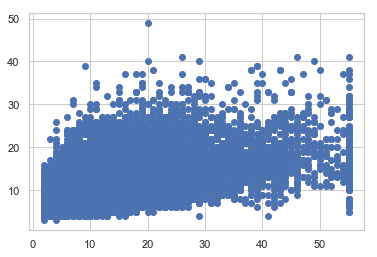

In [395]:
plt.scatter(y_test_antilog,predicted_delivery_time)

### Applying Ridge 

In [396]:
import math
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [397]:
steps = [('scalar', StandardScaler()),('poly', PolynomialFeatures(degree=1)),('model', Ridge(alpha=10, fit_intercept=True))]

ridge_pipe = Pipeline(steps)
ridge_pipe.fit(X_train, y_train)

print('Training Score: {}'.format(ridge_pipe.score(X_train, y_train)))
print('Test Score: {}'.format(ridge_pipe.score(X_test, y_test)))

Training Score: 0.4061011386289396
Test Score: 0.4043520168801915


#### Ridge does not have much effect on the score, but actually increases rmse

In [398]:
df_out.head()

,price,freight_value,customer_state,product_description_lenght,product_photos_qty,product_category_name,review_score,estimated_delivery_time,actual_delivery_time
0,3.433665,2.274186,SP,268,4,housewares,4.0,2.772589,2.197225
1,4.784989,3.168003,BA,178,1,perfumery,4.0,2.890372,2.564949
2,5.080783,3.006672,GO,232,1,auto,5.0,3.295837,2.302585
3,3.828641,3.339322,RN,468,3,pet_shop,5.0,3.295837,2.639057
4,3.039749,2.274186,SP,316,4,stationery,5.0,2.564949,1.098612


### Applying Lasso

training score: 7.654100667164876e-06
test score:  -5.044366346629303e-06
number of features used:  1
training score for alpha=0.01: 0.3831184705726167
test score for alpha =0.01:  0.3853577635680427
number of features used: for alpha =0.01: 7
training score for alpha=0.0001: 0.4054491462091665
test score for alpha =0.0001:  0.40455096408915914
number of features used: for alpha =0.0001: 68
LR training score: 0.4061011413080896
LR test score:  0.404351873305724


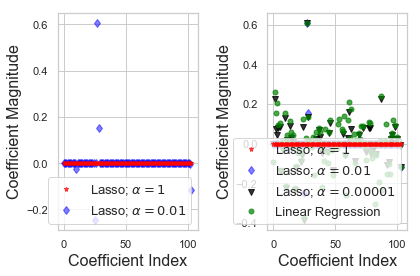

In [399]:
import math 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
# difference of lasso and ridge regression is that some of the coefficients can be zero i.e. some of the features are 
# completely neglected
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


lasso = Lasso()
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print ("training score:", train_score) 
print ("test score: ", test_score)
print ("number of features used: ", coeff_used)

lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train,y_train)
train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)
print ("training score for alpha=0.01:", train_score001)
print ("test score for alpha =0.01: ", test_score001)
print ("number of features used: for alpha =0.01:", coeff_used001)

lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X_train,y_train)
train_score00001=lasso00001.score(X_train,y_train)
test_score00001=lasso00001.score(X_test,y_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)
print ("training score for alpha=0.0001:", train_score00001) 
print ("test score for alpha =0.0001: ", test_score00001)
print ("number of features used: for alpha =0.0001:", coeff_used00001)

lr = LinearRegression()
lr.fit(X_train,y_train)
lr_train_score=lr.score(X_train,y_train)
lr_test_score=lr.score(X_test,y_test)
print ("LR training score:", lr_train_score) 
print ("LR test score: ", lr_test_score)
plt.subplot(1,2,1)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.subplot(1,2,2)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency
plt.plot(lasso00001.coef_,alpha=0.8,linestyle='none',marker='v',markersize=6,color='black',label=r'Lasso; $\alpha = 0.00001$') # alpha here is for transparency
plt.plot(lr.coef_,alpha=0.7,linestyle='none',marker='o',markersize=5,color='green',label='Linear Regression',zorder=2)
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.tight_layout()
plt.show()

#### Clearly, applying Lasso has no effect on our score either

###############################################################################################################################################

### Hence, our final R2 score is : 0.4834
### and RMSE value is : 0.4111

### And following is our test values and predicted values for delivery time in days

In [400]:
result_dict = {'test_delivery_time': y_test_antilog,'predicted_delivery_time': predicted_delivery_time}
results = pd.DataFrame(result_dict)
results.head(10)

,test_delivery_time,predicted_delivery_time
0,5,7
1,5,10
2,42,27
3,26,25
4,10,9
5,10,8
6,55,19
7,15,8
8,13,12
9,11,8
